In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [3]:
#  ______ ______ _   _
# |  ____|  ____| \ | |
# | |__  | |__  |  \| |
# |  __| |  __| | . ` |
# | |____| |    | |\  |
# |______|_|    |_| \_|
#  ________   __          __  __ _____  _      ______
# |  ____\ \ / /    /\   |  \/  |  __ \| |    |  ____|
# | |__   \ V /    /  \  | \  / | |__) | |    | |__
# |  __|   > <    / /\ \ | |\/| |  ___/| |    |  __|
# | |____ / . \  / ____ \| |  | | |    | |____| |____
# |______/_/ \_\/_/    \_\_|  |_|_|    |______|______|

# EnergyFlow - Python package for high-energy particle physics.
# Copyright (C) 2017-2020 Patrick T. Komiske III and Eric Metodiev

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from tqdm import tqdm

2023-04-16 14:14:33.518512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
################################### SETTINGS ##################################
# the commented values correspond to those in 1810.05165
###############################################################################

# data controls, can go up to 2000000 total for full dataset
train, val, test = 75000, 10000, 15000
# train, val, test = 1000000, 200000, 200000

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)
# Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 5
batch_size = 500

In [5]:
# load data
X, y = qg_jets.load(train + val + test, cache_dir="/usatlas/atlas01/atlasdisk/users/atlas_wifeng/phys427/top-tagging/.energyflow")

# ignore pid information
X = X[:,:,:3]

# convert labels to categorical
Y = to_categorical(y, num_classes=2)

print('Loaded quark and gluon jets')

# preprocess by centering jets and normalizing pts
for x in tqdm(X):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

Loaded quark and gluon jets


100%|██████████| 100000/100000 [00:21<00:00, 4610.77it/s]

Finished preprocessing


In [10]:
# do train/val/test split 
(z_train, z_val, z_test, 
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

print('Done train/val/test split')

Done train/val/test split


In [6]:
# build architecture
efn = EFN(input_dim=2, Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 2)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 100)    300         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 100)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 100)    10100       ['activation[0][0]']             
                                                                                              

In [12]:
print(z_train.shape, p_train.shape)
print(Y_train.shape)

(75000, 139) (75000, 139, 2)
(75000, 2)


In [8]:
# train model
efn.fit([z_train, p_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, p_val], Y_val),
        verbose=1)

Epoch 1/5
150/150 [==============================] - 1s 9ms/step - loss: 0.4977 - acc: 0.7625 - val_loss: 0.4990 - val_acc: 0.7591
Epoch 2/5
150/150 [==============================] - 1s 9ms/step - loss: 0.4922 - acc: 0.7658 - val_loss: 0.4915 - val_acc: 0.7630
Epoch 3/5
150/150 [==============================] - 1s 9ms/step - loss: 0.4872 - acc: 0.7696 - val_loss: 0.4842 - val_acc: 0.7679
Epoch 4/5
150/150 [==============================] - 1s 9ms/step - loss: 0.4866 - acc: 0.7711 - val_loss: 0.4844 - val_acc: 0.7684
Epoch 5/5
150/150 [==============================] - 1s 9ms/step - loss: 0.4835 - acc: 0.7731 - val_loss: 0.4856 - val_acc: 0.7655


In [9]:
# get predictions on test data
preds = efn.predict([z_test, p_test], batch_size=1000)

15/15 [==============================] - 0s 5ms/step



EFN AUC: 0.8395697670763815



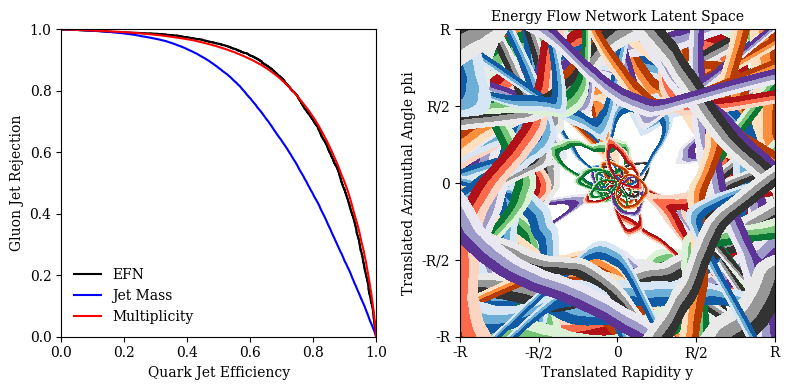

In [10]:
# get ROC curve
efn_fp, efn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('EFN AUC:', auc)
print()

# some nicer plot settings 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

fig, axes = plt.subplots(1, 2, figsize=(8,4))

######################### ROC Curve Plot #########################

# get multiplicity and mass for comparison
masses = np.asarray([ef.ms_from_p4s(ef.p4s_from_ptyphims(x).sum(axis=0)) for x in X])
mults = np.asarray([np.count_nonzero(x[:,0]) for x in X])
mass_fp, mass_tp, threshs = roc_curve(Y[:,1], -masses)
mult_fp, mult_tp, threshs = roc_curve(Y[:,1], -mults)

# plot the ROC curves
axes[0].plot(efn_tp, 1-efn_fp, '-', color='black', label='EFN')
axes[0].plot(mass_tp, 1-mass_fp, '-', color='blue', label='Jet Mass')
axes[0].plot(mult_tp, 1-mult_fp, '-', color='red', label='Multiplicity')

# axes labels
axes[0].set_xlabel('Quark Jet Efficiency')
axes[0].set_ylabel('Gluon Jet Rejection')

# axes limits
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

# make legend and show plot
axes[0].legend(loc='lower left', frameon=False)

######################### Filter Plot #########################

# plot settings
R, n = 0.4, 100
colors = ['Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']
grads = np.linspace(0.45, 0.55, 4)

# evaluate filters
X, Y, Z = efn.eval_filters(R, n=n)

# plot filters
for i,z in enumerate(Z):
    axes[1].contourf(X, Y, z/np.max(z), grads, cmap=colors[i%len(colors)])

axes[1].set_xticks(np.linspace(-R, R, 5))
axes[1].set_yticks(np.linspace(-R, R, 5))
axes[1].set_xticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_yticklabels(['-R', '-R/2', '0', 'R/2', 'R'])
axes[1].set_xlabel('Translated Rapidity y')
axes[1].set_ylabel('Translated Azimuthal Angle phi')
axes[1].set_title('Energy Flow Network Latent Space', fontdict={'fontsize': 10})

plt.show()